# Recommend RBS sequences - Escherichia coli

This notebook shows the online recommendation of RBS sequences with the goal of achieving a high protein expression level.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - One-hot embedding
    - K-mer 
    - PMW
    - Kernels
    - Unsupervised 
- Create reward environment
- Apply bandits algorithms
    - GPUCB

## Some open questions

- How to define arms? In this notebook, we consider an RBS sequence is an arm, where arms are dependent (we assume similar sequences having similar protein expression levels). Are there any other ways to define arms? For example, how about define arms as different experts, where each expert recommends one arm.

- How to recommend multiple arms once?

- How to select embedding methods? How to evaluate them?

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_list.xlsx'

df = pd.read_excel(Path, sheet_name='Unique RBS')
df.columns = ['A', 'B', 'C', 'D', 'E', 'F']
df.head()

,A,B,C,D,E,F
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,AAGTAAGCGGGGA,57706.0,NaN,AAGTAAGCGGGGA,57706.0
1,ACGATCTTAAGTAGACGCGGAAAATAATG,AAGTAGACGCGGA,613.0,NaN,AAGTAGACGCGGA,613.0
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,AAGTAAGCGCGGA,5313.0,NaN,AAGTAAGCGCGGA,5313.0
3,ACGATCTTAAGTAAACGAGGAAAATAATG,AAGTAAACGAGGA,19594.0,NaN,AAGTAAACGAGGA,19594.0
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,AAGTAGGCGAGGA,33626.0,NaN,AAGTAGGCGAGGA,33626.0


In [4]:
new_df = df[['E', 'F']].dropna()
# mean normalization 
# new_df['normalized_F'] = (new_df['F'] - new_df['F'].mean())/new_df['F'].std()
# min-max normalization
new_df['normalized_F'] = (new_df['F'] - new_df['F'].min())/(new_df['F'].max() - new_df['F'].min())
data = np.asarray(new_df[['E', 'normalized_F']])
data

array([['AAGTAAGCGGGGA', 0.6626211618030668],
       ['AAGTAGACGCGGA', 0.004861794841013548],
       ['AAGTAAGCGCGGA', 0.05900974686178055],
       ['AAGTAAACGAGGA', 0.22353887511892387],
       ['AAGTAGGCGAGGA', 0.3851993140030521],
       ['AAGTAGGCGCGGA', 0.033468042685176204],
       ['AAGTAAACGGGGA', 0.1483653885369016],
       ['AAGTAGACGAGGA', 0.07444767360812689],
       ['AAGTAGGCGGGGA', 0.20411473743658065],
       ['AAGTAGACGGGGA', 0.03861785854757681],
       ['CATCTAAGGGGGA', 0.5786572736483115],
       ['CATCTAAGGGGGA', 0.5786572736483115],
       ['CATCTAAGAGGGG', 0.3063967625515529],
       ['CATCTAAGGGGGG', 0.7918389128381569],
       ['CATCTAAGGGGGC', 0.1625360227891449],
       ['CATCTAAGAGGGA', 0.05373320174996964],
       ['CATCTAAGAGCGA', 0.005495441088065077],
       ['CATCTAAGGGCGG', 0.08771968227364255],
       ['CATCTAAGAGGGC', 0.05373320174996964],
       ['CATCTAAGGGCGC', 0.010472444337633448],
       ['CATCTAAGAGCGG', 0.02262693144016732],
       ['CATCTAAG

## Regression

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='precomputed',
            kernel_params=None)
Train score:  0.4914512690467552
Test score:  0.22444739183374285


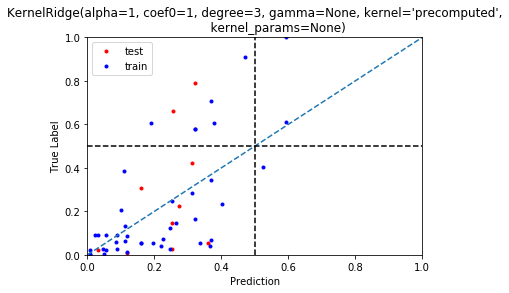

In [5]:
# use spectrum kernel (l = 3) + none embedding 
reg = Regression(KernelRidge(kernel = 'precomputed'), data, embedding_method=None, precomputed_kernel='spectrum')
reg.train()
reg.evaluate()

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=precomputed),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train score:  0.5879859179750311
Test score:  0.1022739373554552


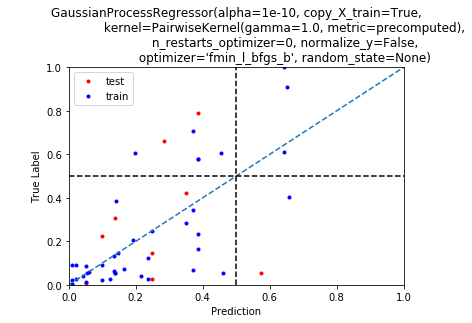

In [6]:
# use spectrum kernel + none embedding
# should be same as DotProduct kernel + kmer embedding? check whether exists bugs

from sklearn.gaussian_process.kernels import PairwiseKernel
reg = Regression(GaussianProcessRegressor(kernel = PairwiseKernel(metric = 'precomputed')), data,\
                 embedding_method=None, precomputed_kernel='spectrum')
reg.train()
reg.evaluate()

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='precomputed',
            kernel_params=None)
Train score:  0.4432247607086609
Test score:  0.11470741909189443


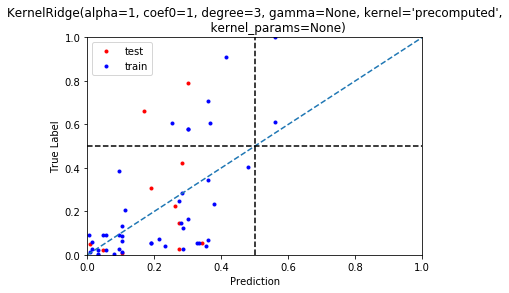

In [7]:
# use mixed spectrum kernel (l = 3) + none embedding 
reg = Regression(KernelRidge(kernel = 'precomputed'), data, embedding_method=None, precomputed_kernel='mixed_spectrum')
reg.train()
reg.evaluate()

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='precomputed',
            kernel_params=None)
Train score:  0.7449064532607694
Test score:  0.28304787529173026


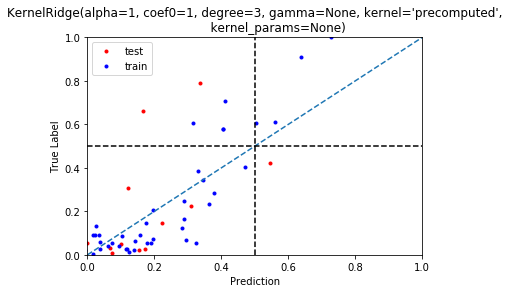

In [8]:
# use weighted degree kernel (l = 3) + none embedding 
reg = Regression(KernelRidge(kernel = 'precomputed'), data, embedding_method=None, precomputed_kernel='WD')
reg.train()
reg.evaluate()

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='precomputed',
            kernel_params=None)
Train score:  0.7433299448061463
Test score:  0.30235215664537096


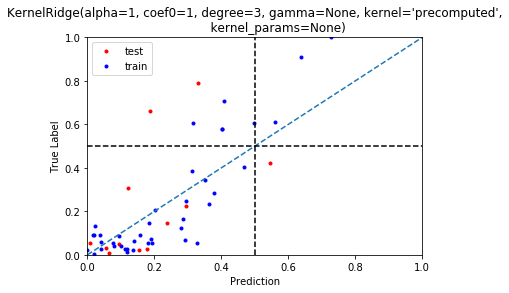

In [9]:
# use WD shift kernel (l = 3) + none embedding 
reg = Regression(KernelRidge(kernel = 'precomputed'), data, embedding_method=None, precomputed_kernel='WD_shift')
reg.train()
reg.evaluate()

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train score:  0.35191514162136195
Test score:  -0.21116320967833624


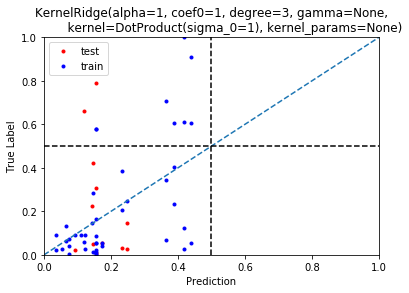

In [10]:
# use dot product kernel + kmer embedding (k = 3) 
reg = Regression(KernelRidge(kernel = DotProduct()), data, 'kmer')
reg.train()
reg.evaluate()

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train score:  0.3790821153279642
Test score:  -0.31394716763703845


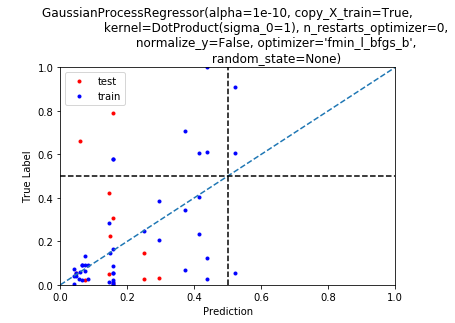

In [11]:
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.train()
reg.evaluate()

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train score:  0.6037840638927897
Test score:  0.07608128395500224


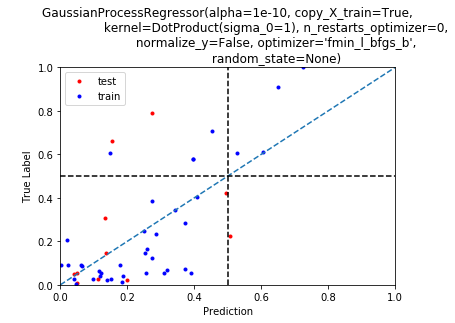

In [12]:
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.train()
reg.evaluate()

## Embedding & Create Rewards Environment

In [12]:
my_env = Rewards_env(data, 'onehot')

## Recommendations with GPUCB

In [13]:
num_rounds = 100
num_exper = 1
init_per = 0.2

sds = []
rs = []

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


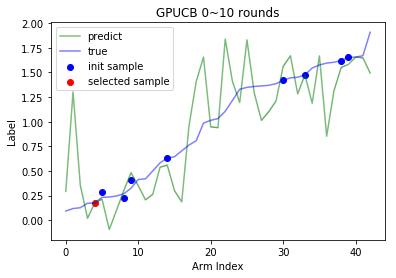

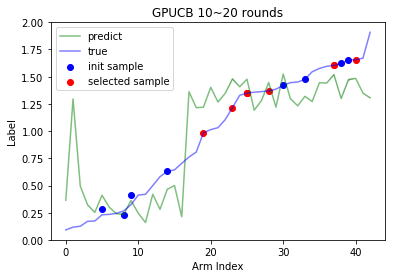

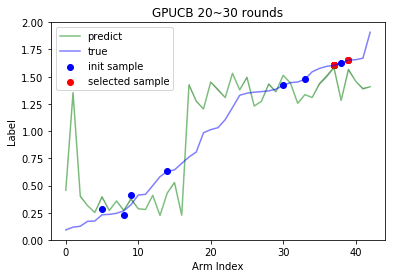

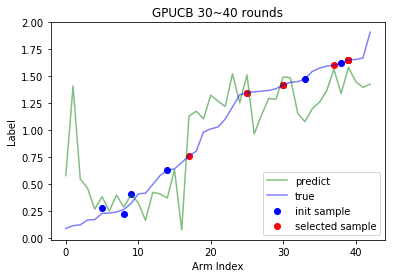

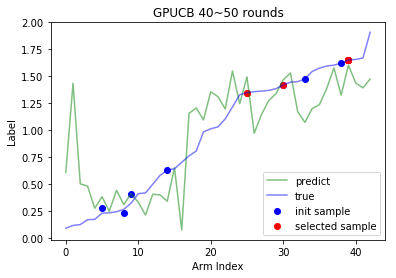

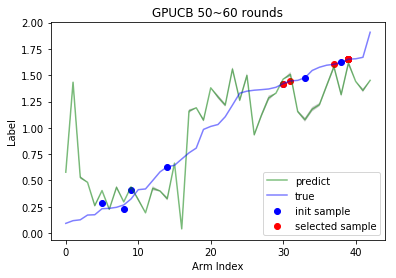

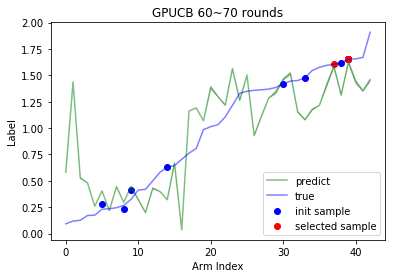

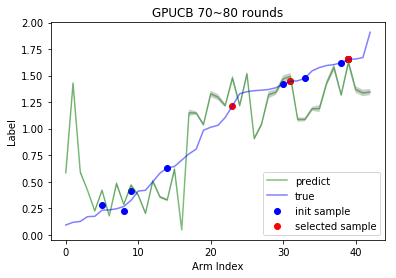

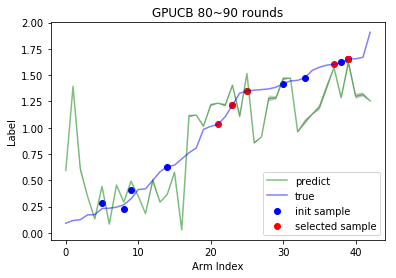

In [14]:
warnings.filterwarnings(action='ignore')

p = IntProgress(max = num_exper)
p.description = 'Running'
display(p)

for i in range(num_exper):
    p.value += 1
    agent = GPUCB(my_env, num_rounds, init_per)
    agent.play(plot_flag = True)
    sds.append(agent.suboptimalDraws)
    rs.append(agent.cumulativeRegrets)

In [15]:
results = evaluate(sds, rs)

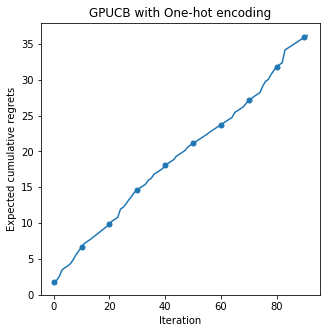

In [16]:
plot_eva(results, 'r')

In [13]:
list('aabc')

['a', 'a', 'b', 'c']